In [308]:
#statistical
import pandas as pd
import numpy as np

#dataset
from sklearn.datasets import *

#mchine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, r2_score, accuracy_score

#graphing and display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

#feature engineer
import feature_engineer as fe

In [309]:
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)
df = pd.DataFrame(np.c_[pos.flat, step, walk],
                  columns=["position", "step", "walk"])

In [310]:
df.head()

,position,step,walk
0,0,0,0
1,1,1,0
2,1,2,0
3,1,3,0
4,0,4,0


In [311]:
def display_metrics(y_test, y_pred):
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average = 'weighted')))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average = 'weighted')))
    print('F1 score: {:.2f}'.format(f1_score(y_test, y_pred, average = 'weighted')))

def train_and_predict(model, X_train, X_test, y_train):
    logistic_clf.fit(X_train, y_train)
    y_pred = logistic_clf.predict(X_test)
    return y_pred

def append_metric_results(df, metrics, y_test, y_pred, dataset_name, enriched_flag, columns):
    for metric_name, metric in metrics.items():
        to_append = pd.DataFrame([[dataset_name,
                                   enriched_flag,
                                   metric_name,
                                   metric['metric'](y_test, y_pred, **metric['kwargs'])]], columns = columns)
        df = df.append(to_append, ignore_index = True)
    
    return df

def get_results_before_after_enrichment(dataset, dataset_name, model, scorer,
                                        splitter, hyperparameters, results = None):
    
    metrics = {'accuracy' : {'metric' : accuracy_score, 'kwargs' : {'normalize' : True}},
               'precision' : {'metric' : precision_score, 'kwargs' : {'average' : 'weighted'}},
               'recall' : {'metric' : recall_score, 'kwargs' : {'average' : 'weighted'}},
               'f1_score' : {'metric' : f1_score, 'kwargs' : {'average' : 'weighted'}}}
    
    dataset_x = pd.DataFrame(dataset[0], columns = ['col_' + str(i) for i in range(dataset[0].shape[1])])
    dataset_y = dataset[1]
    
    X_train, X_test, y_train, y_test = splitter(dataset_x.copy(), dataset_y, **hyperparameters['splitter_kwargs'])
    
    y_pred_not_enriched = train_and_predict(model, X_train, X_test, y_train)
    
    results = append_metric_results(results, metrics, y_test, y_pred_not_enriched,
                                    dataset_name, False, results.columns)
    
    eng = fe.FeatureEngineer(model, scorer, splitter, n_best = hyperparameters['n_best'],
                             scorer_kwargs = hyperparameters['scorer_kwargs'],
                             splitter_kwargs = hyperparameters['splitter_kwargs'])
    eng.fit(X_train, y_train)
    
    eng.transform(X_train)
    eng.transform(X_test)
    
    y_pred_enriched = train_and_predict(model, X_train, X_test, y_train)
    
    results = append_metric_results(results, metrics, y_test, y_pred_enriched,
                                    dataset_name, True, results.columns)
    
    return results

In [312]:
iris = load_iris(return_X_y = True)
boston_housing = load_boston(return_X_y = True)
diabetes = load_diabetes(return_X_y = True)
linnerud = load_linnerud(return_X_y = True)
wine = load_wine(return_X_y = True)
breast_cancer = load_breast_cancer(return_X_y = True)

In [313]:
random_seed = 42
test_size = 0.3
hyperparameters = {'random_seed' : random_seed,
                   'test_size' : test_size,
                   'n_best' : 5,
                   'splitter_kwargs' : {'test_size' : test_size, 'random_state' : random_seed},
                   'scorer_kwargs' : {'average' : 'weighted'}}

In [314]:
datasets = {'iris' : iris,
            #'boston_housing' : boston_housing,
            'diabetes' : diabetes,
            #'linnerud' : linnerud,
            'wine' : wine,
            'breast_cancer' : breast_cancer}

In [315]:
results = pd.DataFrame(columns = ['dataset', 'enriched', 'metric', 'value'])

for dataset_name, dataset in datasets.items():
    print('processing ', dataset_name)
    results = get_results_before_after_enrichment(dataset, dataset_name, LogisticRegression(), f1_score,
                                        train_test_split, hyperparameters, results)

processing  iris


C:\Users\rossr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


processing  diabetes


C:\Users\rossr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\rossr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


processing  wine
processing  breast_cancer


In [316]:
results.sort_values(by = ['dataset', 'metric', 'enriched']).head()

,dataset,enriched,metric,value
24,breast_cancer,False,accuracy,0.964912
28,breast_cancer,True,accuracy,0.982456
27,breast_cancer,False,f1_score,0.964790
31,breast_cancer,True,f1_score,0.982484
25,breast_cancer,False,precision,0.964954


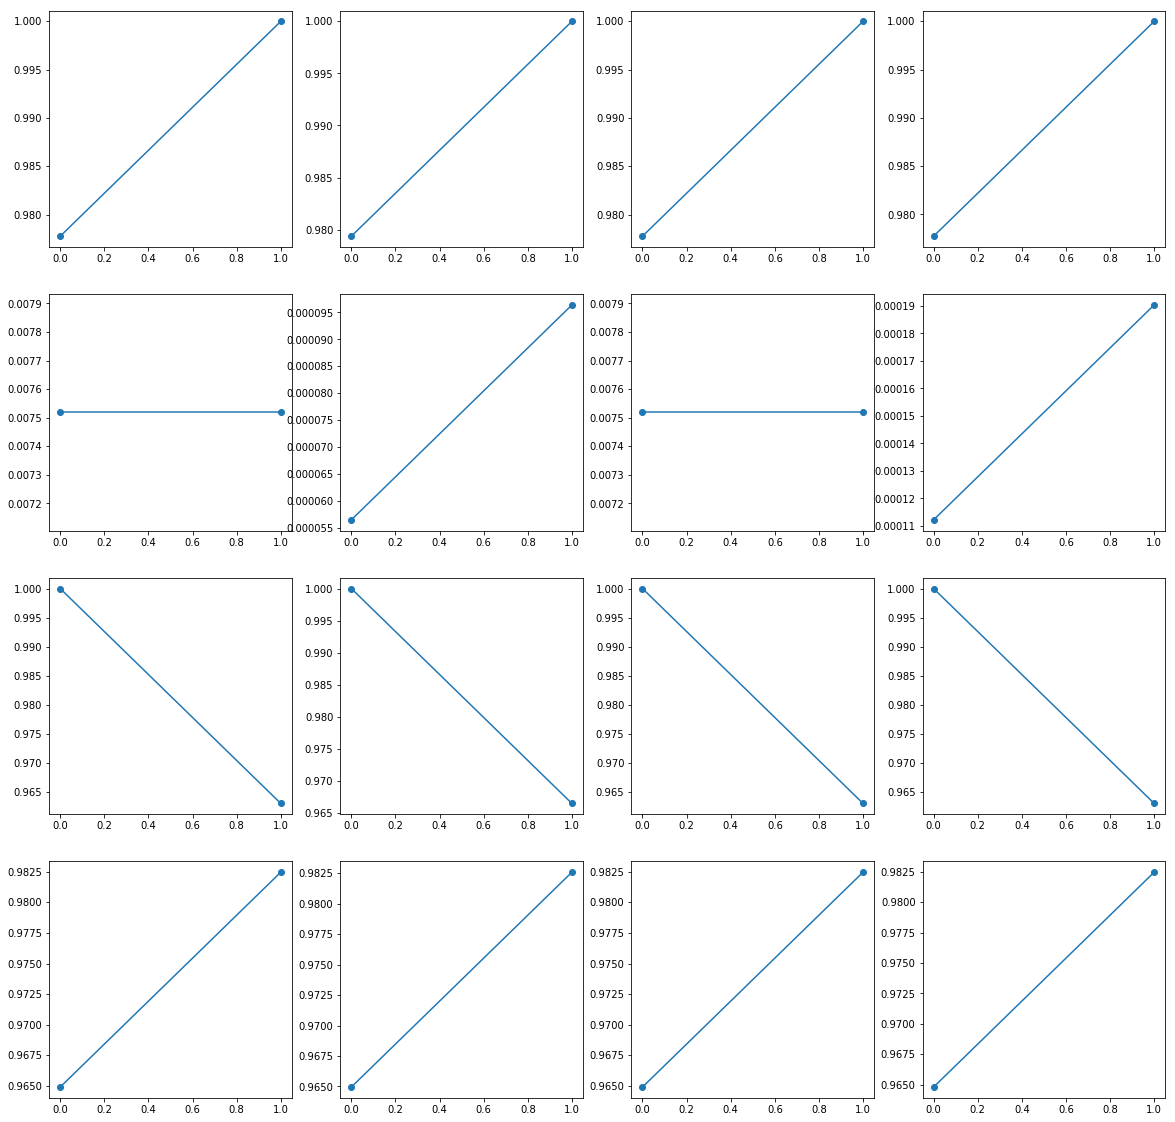

In [317]:
fig = plt.figure(figsize = (20, 20))
len_x = len(results.dataset.unique())
len_y = len(results.metric.unique())
i = 0
for dataset in results.dataset.unique():
    for metric in results.metric.unique():
        i += 1
        ax = plt.subplot(len_x, len_y, i)
        to_plot = results[(results.dataset == dataset) & (results.metric == metric)]
        x_ticks = np.arange(len(to_plot.enriched))
        ax.plot(x_ticks, to_plot.value, marker = 'o')
        ax.set_xticks(x_ticks, to_plot.enriched.tolist())

In [318]:
#iris_x = pd.DataFrame(iris[0], columns = ['col_' + str(i) for i in range(iris[0].shape[1])])
#iris_y = iris[1]

In [319]:
#logistic_clf = LogisticRegression()

In [320]:
#X_train, X_test, y_train, y_test = train_test_split(iris_x.copy(), iris_y,
#                                                    test_size = hyperparameters['test_size'],
#                                                    random_state = hyperparameters['random_seed'])

In [321]:
#y_pred = train_and_predict(logistic_clf, X_train, X_test, y_train)
#display_metrics(y_test, y_pred)

In [322]:
#eng = fe.FeatureEngineer(logistic_clf, f1_score, train_test_split, n_best = 15,
#                         scorer_kwargs = hyperparameters['scorer_kwargs'],
#                         splitter_kwargs = hyperparameters['splitter_kwargs'])
#eng.fit(X_train, y_train)

In [323]:
#for i, s in enumerate(sorted(eng.best_columns, reverse = True)):
#    print(i, s, eng.best_columns[s]['column_name'])

In [324]:
#eng.transform(X_train)
#eng.transform(X_test)

In [325]:
#X_test.head()

In [326]:
#y_pred = train_and_predict(logistic_clf, X_train, X_test, y_train)
#display_metrics(y_test, y_pred)